In [247]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from sklearn.datasets import make_blobs, make_moons
import random
import json
import time
from tabulate import tabulate
from sklearn.datasets import load_iris
from sklearn.mixture import GaussianMixture
import itertools
from kdtree import *
from utils import *

In [248]:
savefile = "data.json"
points_count = 100
to_plot = True
no_centres = 3

In [249]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

# Initialize the parameters
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt

# Initialize the parameters
noise = 0.05  # Amount of noise

# Generate the data
X, y = make_circles(n_samples=points_count, noise=noise, factor=0.5, random_state=41)

# Convert the data to a list of tuples
points = [(x, y) for x, y in X]
# points = [(round(x , 1), round(y , 1)) for x, y in X]
maxdis = math.ceil(math.log2(points_count))

In [250]:
def generate_spiral_data(points_count, noise=0.05):
    n = np.sqrt(np.random.rand(points_count)) * 780 * (2 * np.pi) / 360
    d1x = -np.cos(n) * n + np.random.rand(points_count) * noise
    d1y = np.sin(n) * n + np.random.rand(points_count) * noise
    d2x = np.cos(n) * n + np.random.rand(points_count) * noise
    d2y = -np.sin(n) * n + np.random.rand(points_count) * noise

    X = np.vstack((np.append(d1x, d2x), np.append(d1y, d2y))).T
    y = np.hstack((np.zeros(points_count), np.ones(points_count)))

    return X, y

In [251]:
X, y = make_moons(n_samples=points_count, noise=noise, )

# Convert the data to a list of tuples
points = [(x, y) for x, y in X]

In [252]:
noise = 0.05

# Generate spiral dataset
X, y = generate_spiral_data(points_count, noise)

# Convert the data to a list of tuples
points = [(x, y) for x, y in X]

In [253]:
# X, Y = make_blobs(n_samples=points_count, centers=no_centres,cluster_std=1.7 ,random_state=42)
# points = [(x, y) for x, y in X]

In [254]:
n_samples = [100, 200, 300, 400, 500, 600]
centers = [(5, 5), (15, 15), (25, 25), (10, 20), (30, 10), (35, 35)]
cluster_std = [1.0, 2.0, 1.5, 2.5, 1.0, 1.0]

# Generate the blobs
X, y = make_blobs(
    n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=42
)
points = [(x, y) for x, y in X]
# points = [(round(x , 1), round(y , 1)) for x, y in X]
maxdis = math.ceil(math.log2(points_count))

In [255]:
dcran_start_time = time.time()

In [256]:
def build():
    tree = KDTree()
    tree.root = tree.build(points)

    G = nx.Graph()

    for point in points:
        G.add_node(point , pos = point)

    neighbours = {}
    maxdis = math.ceil(math.log2(points_count))
    for point in points:
        neighbours[point] = i_neighbors(tree, point, maxdis)
    return  G,  neighbours
    

In [257]:
def merge_comps(core1 , core2, core_points_map , mst):
    pivot2 = min(core_points_map[core2], key=lambda node: euclidean_distance(node, core1))
    pivot1 = min(core_points_map[core1], key=lambda node: euclidean_distance(node, pivot2))
    mst.add_edge(pivot1, pivot2 , weight = euclidean_distance(pivot1, pivot2))
    print(f"merging {core1} and {core2} with pivot {pivot1} and {pivot2}")

In [258]:
def merge_phase(G):
    core_points_map = {}
    for component in nx.connected_components(G):
        centroid = np.mean([node for node in component], axis=0)
        closest_point = min(component, key=lambda node: euclidean_distance(node, centroid))
        core_points_map[closest_point] = component

    core_points = list(core_points_map.keys())

    minc = [float("inf")] * len(core_points[0])
    maxc = [float("-inf")] * len(core_points[0])

    for point in core_points:
        for i in range(len(point)):
            minc[i] = min(minc[i], point[i])
            maxc[i] = max(maxc[i], point[i])

    diff = [maxc[i] - minc[i] for i in range(len(minc))]
    min_diff_axis = diff.index(max(diff))

    sorted_core_points = sorted(core_points, key=lambda point: point[min_diff_axis])
    for core1 , core2 in zip(sorted_core_points, sorted_core_points[1:]):
        merge_comps(core1, core2, core_points_map, G)
        
    
    

In [259]:
def dcrun():
    import numpy as np

    G, neighbours = build()
    print(G.number_of_nodes(), G.number_of_edges())
    k = 0
    prev_connected_components = np.inf  # Initialize to infinity
    prev_G = G.copy()
    graphify(
        G,
        to_plot,
        bottom_text=f"",
    )
    while k < maxdis:
        connected_components = list(nx.connected_components(G))
        current_connected_components = len(connected_components)

        print("Connected Components : ", current_connected_components)
        print(
            f"The graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges."
        )

        if current_connected_components == 1:
            break

        if current_connected_components == prev_connected_components :

            G = prev_G
            break

        prev_connected_components = current_connected_components
        prev_G = G.copy()

        for component in connected_components:
            for node in component:
                wt, pos = neighbours[node][k]
                if pos in component:
                    continue
                G.add_edge(node, pos, weight=wt)

        graphify(
            G,
            to_plot,
            bottom_text=f"",
        )
        k += 1
    print(
        f"Minimum Spanning Tree: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges, "
    )
    connected_components = list(nx.connected_components(G))
    current_connected_components = len(connected_components)

    print("Connected Components : ", current_connected_components)
    mst = nx.minimum_spanning_tree(G)
    print(mst.number_of_nodes(), mst.number_of_edges())
    mst_weight = round(sum(data["weight"] for u, v, data in mst.edges(data=True)), 2)
    print(
        f"Minimum Spanning Tree: {mst.number_of_nodes()} nodes, {mst.number_of_edges()} edges, Total Weight: {mst_weight}"
    )

    graphify(
        mst,
        to_plot,
        bottom_text=f"Minimum Spanning Tree: {G.number_of_nodes()} nodes, \nTotal Weight: {mst_weight}",
    )

    return mst_weight, G.number_of_edges() , G

2100 0


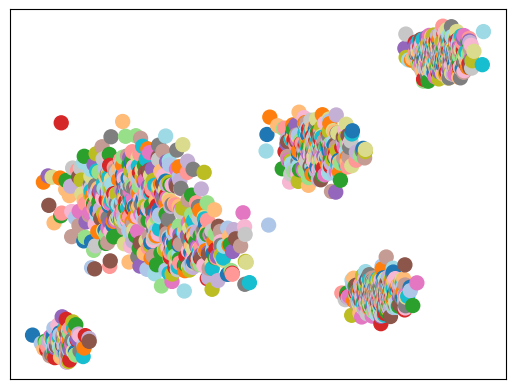

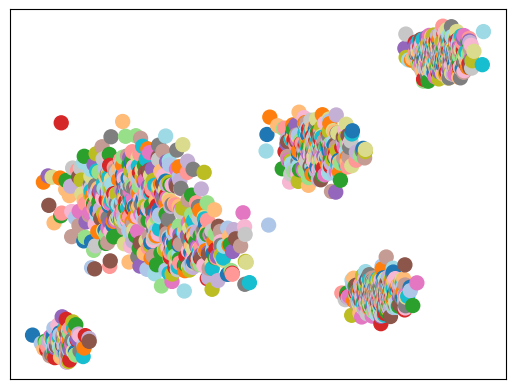

Connected Components :  2100
The graph has 2100 nodes and 0 edges.


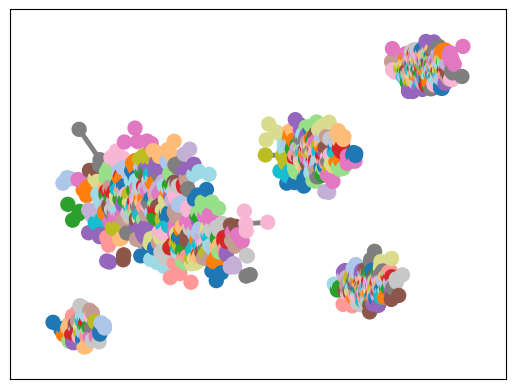

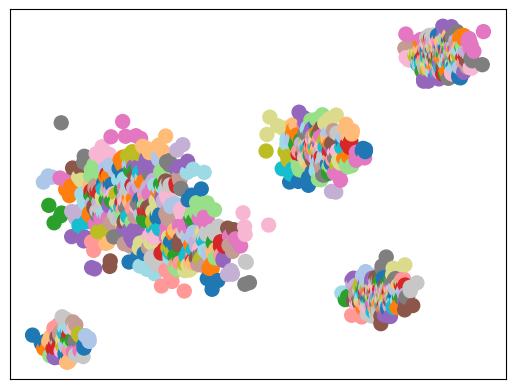

Connected Components :  635
The graph has 2100 nodes and 1465 edges.


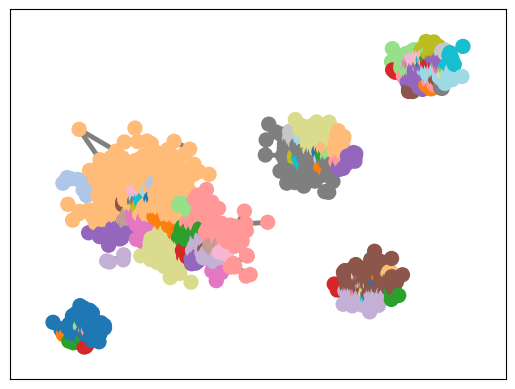

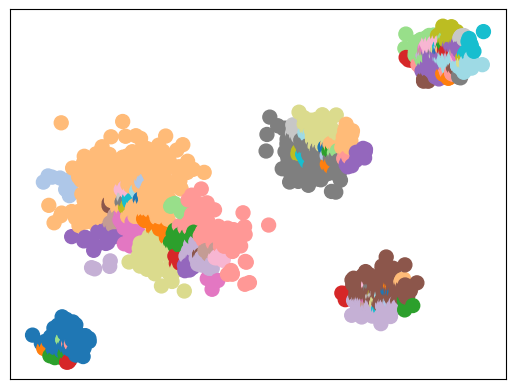

Connected Components :  100
The graph has 2100 nodes and 2252 edges.


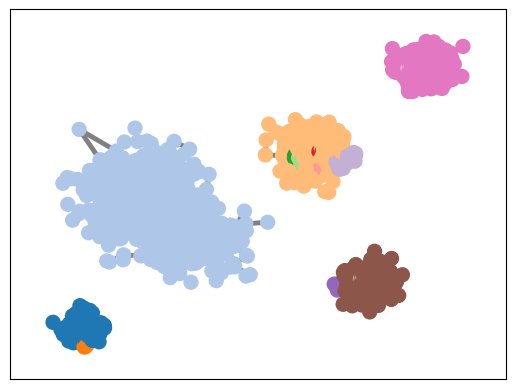

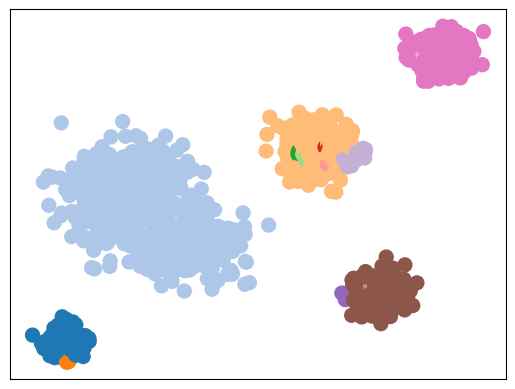

Connected Components :  14
The graph has 2100 nodes and 2495 edges.


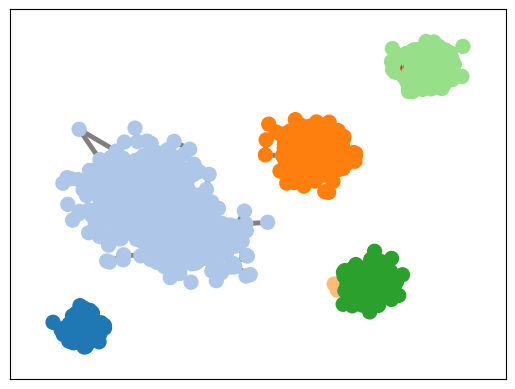

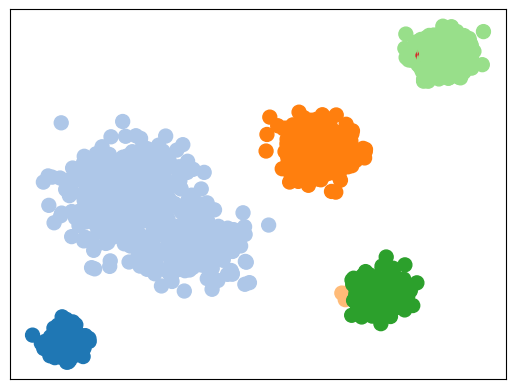

Connected Components :  7
The graph has 2100 nodes and 2518 edges.


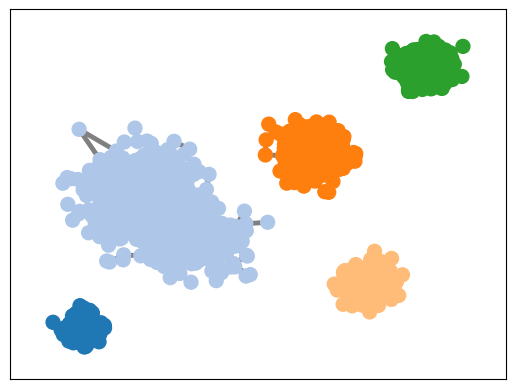

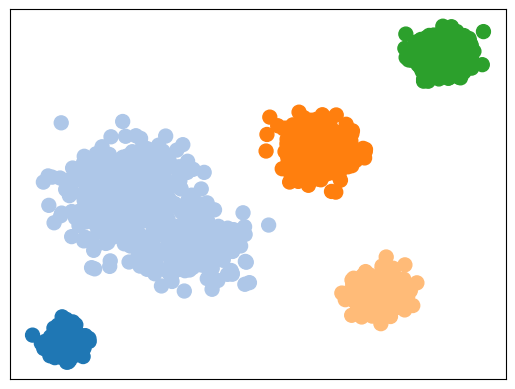

Connected Components :  5
The graph has 2100 nodes and 2525 edges.


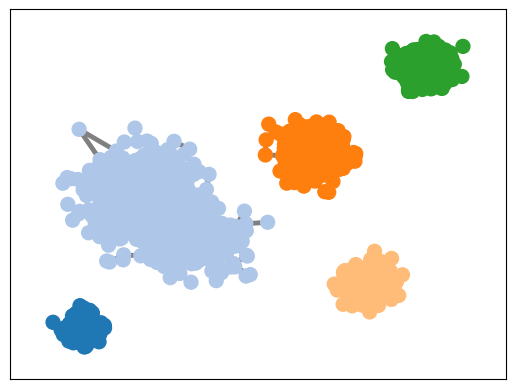

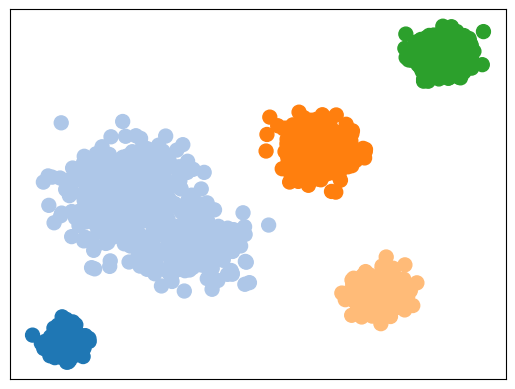

Connected Components :  5
The graph has 2100 nodes and 2525 edges.
Minimum Spanning Tree: 2100 nodes, 2525 edges, 
Connected Components :  5
2100 2095
Minimum Spanning Tree: 2100 nodes, 2095 edges, Total Weight: 459.38


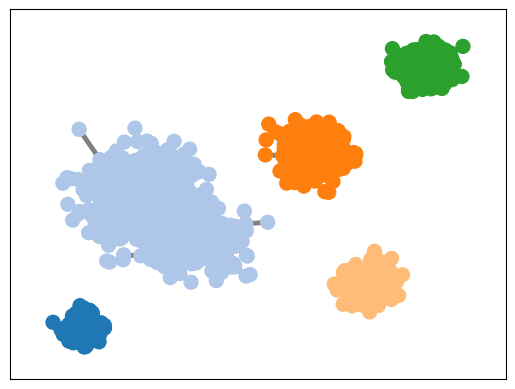

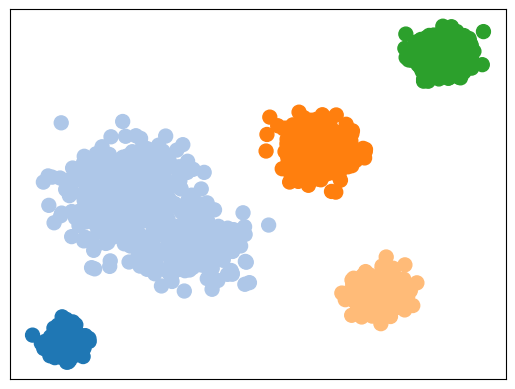

In [260]:
dc_weight, dc_edgecount , G= dcrun()

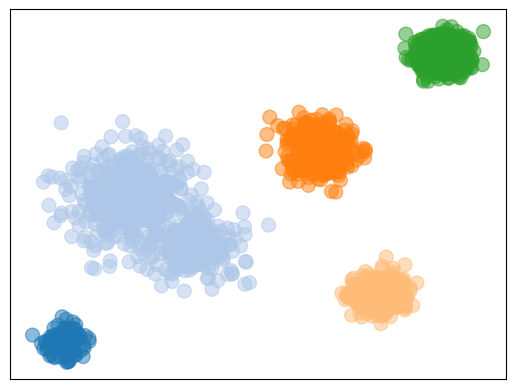

In [261]:
# Find all connected components
connected_components = list(nx.connected_components(G))

# Define a color cycle
colors = itertools.cycle(plt.cm.tab20.colors)

# Create a color map for each node
color_map = {}
for component in connected_components:
    color = next(colors)
    for node in component:
        color_map[node] = color

# Draw the graph with the color map
pos = nx.get_node_attributes(G, "pos")
nx.draw_networkx_nodes(
    G,
    pos,
    node_size=100,
    node_color=[color_map[node] for node in G.nodes()],
    alpha=0.5,
)

plt.show()

In [262]:
dcran_end_time = time.time()
dcran_elapsed_time = dcran_end_time - dcran_start_time

In [263]:
prim_start_time = time.time()

In [264]:
# Gst = nx.Graph()

# for pointi in points:
#     Gst.add_node(pointi, pos=pointi)
    
# for pointi in points:    
#     for pointj in points:
#         if pointi != pointj:
#             dis = euclidean_distance(pointi, pointj)
#             Gst.add_edge(pointi , pointj , weight=dis)

In [265]:
# Gst = nx.minimum_spanning_tree(Gst, algorithm="prim", weight="weight")
# gst_weight = sum(data["weight"] for u, v, data in Gst.edges(data=True))


In [266]:
prim_end_time = time.time()
prim_elapsed_time = prim_end_time - prim_start_time

In [267]:
import math

eprim_start_time = time.time()
def calculate_distance(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)


def prim_mst(points):
    n = len(points)
    visited = [False] * n
    min_cost = [float("inf")] * n
    parent = [None] * n

    min_cost[0] = 0
    parent[0] = -1

    for _ in range(n):
        min_index = -1
        for i in range(n):
            if not visited[i] and (
                min_index == -1 or min_cost[i] < min_cost[min_index]
            ):
                min_index = i

        visited[min_index] = True

        for i in range(n):
            if not visited[i]:
                distance = calculate_distance(points[min_index], points[i])
                if distance < min_cost[i]:
                    min_cost[i] = distance
                    parent[i] = min_index

    mst_edges = []
    for i in range(1, n):
        mst_edges.append((parent[i], i))

    return mst_edges


mst = prim_mst(points)
eprim_end_time = time.time()
eprim_elapsed_time = eprim_end_time - eprim_start_time
print("MST Weight: ", eprim_wt := sum([calculate_distance(points[u], points[v]) for u, v in mst]))
print("time taken by dcran : ", eprim_elapsed_time)

MST Weight:  479.85342223320737
time taken by dcran :  1.2431442737579346


In [268]:
speedup = eprim_elapsed_time / dcran_elapsed_time
print(f"Speedup: {speedup:.2f}")

Speedup: 0.47


In [269]:
wt_error = abs(dc_weight - eprim_wt) / eprim_wt * 100
print(f"Weight Error: {wt_error}%")

Weight Error: 4.266599191462544%


In [270]:
from sklearn.cluster import KMeans
from scipy.sparse.csgraph import minimum_spanning_tree
from scipy.spatial.distance import pdist, squareform

In [271]:
fmst_start_time = time.time()
def euclidean_distance(p1, p2):
    return sum((a - b) ** 2 for a, b in zip(p1, p2)) ** 0.5


def detect_connecting_edge(cluster1, cluster2):
    center1 = [sum(x) / len(cluster1) for x in zip(*cluster1)]
    center2 = [sum(x) / len(cluster2) for x in zip(*cluster2)]

    min_dist1 = float("inf")
    min_point1 = None
    for point in cluster1:
        dist = euclidean_distance(point, center2)
        if dist < min_dist1:
            min_dist1 = dist
            min_point1 = point

    min_dist2 = float("inf")
    min_point2 = None
    for point in cluster2:
        dist = euclidean_distance(point, center1)
        if dist < min_dist2:
            min_dist2 = dist
            min_point2 = point

    return min_point1, min_point2


def fast_mst(points):
    n = len(points)
    k = int(n**0.5)

    # Divide-and-conquer stage
    kmeans = KMeans(n_clusters=k).fit(points)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_.tolist()

    mst_edges = []
    total_weight = 0

    for i in range(k):
        cluster_points = [points[j] for j in range(n) if labels[j] == i]
        pairwise_distances = squareform(pdist(cluster_points))
        mst = minimum_spanning_tree(pairwise_distances).toarray().tolist()
        edges = [
            (u, v)
            for u in range(len(cluster_points))
            for v in range(u + 1, len(cluster_points))
            if mst[u][v] > 0
        ]
        for u, v in edges:
            weight = euclidean_distance(cluster_points[u], cluster_points[v])
            mst_edges.append((cluster_points[u], cluster_points[v]))
            total_weight += weight

    pairwise_distances_centers = squareform(pdist(centers))
    mst_centers = minimum_spanning_tree(pairwise_distances_centers).toarray().tolist()
    center_edges = [
        (i, j) for i in range(k) for j in range(i + 1, k) if mst_centers[i][j] > 0
    ]

    # Refinement stage
    midpoints = []
    for i, j in center_edges:
        cluster1 = [points[m] for m in range(n) if labels[m] == i]
        cluster2 = [points[m] for m in range(n) if labels[m] == j]
        u, v = detect_connecting_edge(cluster1, cluster2)
        mst_edges.append((u, v))
        midpoint = [(a + b) / 2 for a, b in zip(u, v)]
        midpoints.append(midpoint)
        weight = euclidean_distance(u, v)
        total_weight += weight

    kmeans_refine = KMeans(n_clusters=len(midpoints), init=midpoints, n_init=1).fit(
        points
    )
    labels_refine = kmeans_refine.labels_

    for i in range(len(midpoints)):
        cluster_points = [points[j] for j in range(n) if labels_refine[j] == i]
        pairwise_distances = squareform(pdist(cluster_points))
        mst = minimum_spanning_tree(pairwise_distances).toarray().tolist()
        edges = [
            (u, v)
            for u in range(len(cluster_points))
            for v in range(u + 1, len(cluster_points))
            if mst[u][v] > 0
        ]
        for u, v in edges:
            weight = euclidean_distance(cluster_points[u], cluster_points[v])
            mst_edges.append((cluster_points[u], cluster_points[v]))
            total_weight += weight

    return mst_edges, total_weight


# Example usage


mst_edges, fmst_weight = fast_mst(points)
fmst_end_time = time.time()
fmst_edgecount = len(mst_edges)
fmst_elapsed_time = fmst_end_time - fmst_start_time
print("time taken by fast mst : ", fmst_elapsed_time)

print("Total weight of the MST:", fmst_weight)

/home/voy/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


time taken by fast mst :  0.5014967918395996
Total weight of the MST: 503.15197687892993


In [272]:
with open(savefile, "r") as f:
    loaded_data = json.load(f)
print(loaded_data)
currres = []
loaded_data.append(
    [
        points_count,
        no_centres,
        dc_weight,
        fmst_weight,
        eprim_wt,
        dc_edgecount,
        fmst_edgecount,
        abs(fmst_weight - eprim_wt) / eprim_wt * 100,
        abs(dc_weight - eprim_wt) / eprim_wt * 100,
        dcran_elapsed_time,
        fmst_elapsed_time,
        eprim_elapsed_time,
        eprim_elapsed_time / fmst_elapsed_time,
        eprim_elapsed_time / dcran_elapsed_time,
    ]
)
# Save the updated dictionary back to the JSON file
with open(savefile, "r") as f:
    loaded_data = json.load(f)
print(loaded_data)
currres = []
loaded_data.append(
    [
        points_count,
        no_centres,
        dc_weight,
        fmst_weight,
        eprim_wt,
        dc_edgecount,
        len(mst),
        abs(fmst_weight - eprim_wt) / eprim_wt * 100,
        abs(dc_weight - eprim_wt) / eprim_wt * 100,
        dcran_elapsed_time,
        fmst_elapsed_time,
        eprim_elapsed_time,
        eprim_elapsed_time / fmst_elapsed_time,
        eprim_elapsed_time / dcran_elapsed_time,
    ]
)
# Save the updated dictionary back to the JSON file
with open(savefile, "w") as f:
    json.dump(loaded_data, f)

headers = [
    "Points",
    "Centres",
    "DCRAN Wt",
    "FMST Wt",
    "Prim's Wt",
    "dc Edges",
    "Prim's Edges",
    "FMST Acc(%)",
    "DCRAN Acc(%)",
    "DCRAN Time (s)",
    "FMST Time (s)",
    "Prim's Time (s)",
    "Prim's Speedup",
    "DCRAN Speedup",
]
# Format the data as a table using tabulate
table_str = tabulate(
    loaded_data[-15:],
    headers,
    tablefmt="pipe",
    floatfmt=(
        ".0f",
        ".0f",
        ".1f",
        ".1f",
        ".1f",
        ".0f",
        ".0f",
        ".2f",
        ".2f",
        ".2f",
        ".2f",
        ".2f",
        ".2f",
        ".2f",
    ),
)
print(table_str)

[[10000, 10, 877.65, 891.7851946441831, 865.3329904388637, 12089, 9999, 3.0568815123879474, 1.4233837952820403, 2.181704044342041, 8.06056261062622, 30.508898973464966, 3.7849589969371564, 13.983976906760445], [1000, 10, 272.62, 269.3821303743565, 258.81913472345116, 1203, 999, 4.081226707674429, 5.33224303191304, 0.15179872512817383, 0.24590039253234863, 0.2952311038970947, 1.200612576729647, 1.9448852659850162], [100, 10, 94.84, 97.0053015053769, 92.5713108376204, 119, 99, 4.789810825444807, 2.450747582433088, 0.0512537956237793, 0.045298099517822266, 0.0034923553466796875, 0.07709717148962598, 0.06813847255947231], [50000, 10, 1987.54, 2009.5957220693579, 1964.622610853823, 60119, 49999, 2.2891475933889174, 1.166503379303826, 13.07067322731018, 46.351282596588135, 789.9790432453156, 17.043304931187922, 60.43904774504761], [500, 10, 174.12, 196.28644400635744, 182.78398713877627, 586, 499, 7.387111463615035, 4.740014305628561, 0.7871780395507812, 0.19144582748413086, 0.06823921203613